# Multimedia Security and Privacy
## TP2 - Basic Cryptography Watermarking
### Genis Skura
#### The Input Image & The Permuted Image

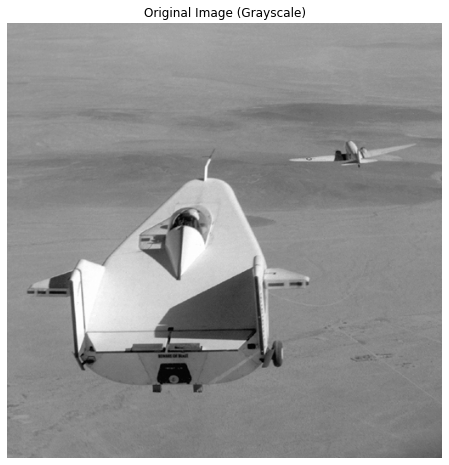

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import skimage
import seaborn as sns
from IPython.display import Image, display
# sns.set()

img = cv.imread('liftingbody.png')
grayscale_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 8))
plt.title('Original Image (Grayscale)')
plt.imshow(grayscale_img, cmap = 'gray')
plt.axis('off')
plt.show()

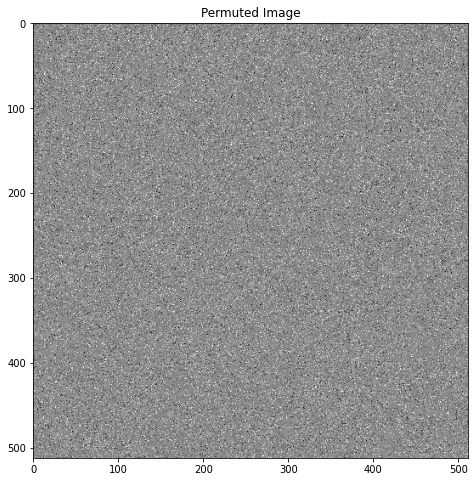

In [2]:
# Permutation of the image
def permute_img(im):
    arr = np.arange(im.shape[0] * im.shape[1]) # Permutation Matrix
    np.random.shuffle(arr)
    
    perm = np.arange(im.shape[0] * im.shape[1])
    flattened = im.flatten()
    for i in range(len(arr)):
        perm[arr[i]] = flattened[i]
    return perm.reshape(im.shape[0], im.shape[0]), arr

def revert_permutation(perm, arr):
    original = np.arange(perm.shape[0] * perm.shape[1])
    flattened = perm.flatten()
    for i in range(len(flattened)):
        original[i] = flattened[arr[i]]
    return original.reshape(perm.shape[0], perm.shape[1])


permuted_img, permutation_matrix = permute_img(grayscale_img)

plt.figure(figsize=(8, 8))
plt.title('Permuted Image')
plt.imshow(permuted_img, cmap = 'gray')
plt.show()

#### Histograms (Image vs Permuted) 

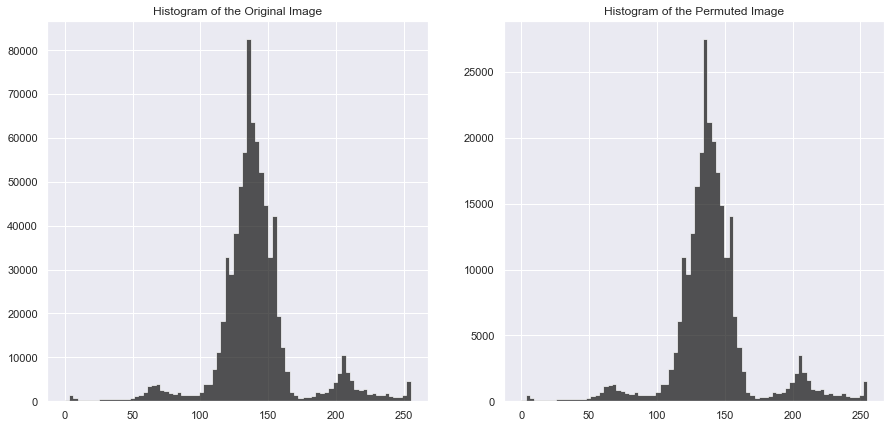

In [3]:
sns.set()

fig1, axes = plt.subplots(1, 2, figsize = (15, 7))
ax = axes.ravel()

ax[0].set_title('Histogram of the Original Image')
ax[0].hist(img.ravel(), bins = 80, range = [0, 255], color = 'black', histtype = 'stepfilled', alpha = 0.66)

ax[1].set_title('Histogram of the Permuted Image')
ax[1].hist(permuted_img.ravel(), bins = 80, range = [0, 255], color = 'black', histtype = 'stepfilled', alpha = 0.66)
plt.show()

We could notice from the histograms that *no matter* the modification, flipping or permutation of the image matrix, the distribution of pixels at large doesn't change so the histograms of the distributions are the same. Since we are merely changing the positions not the values of the pixels themselves. These histograms can be interpreted as the proof of the property of reversibility of a permutation of an image. That given that we know how we permuted the image in the first place, we could always revert back to it.

#### Block Loss Function

(512, 512)


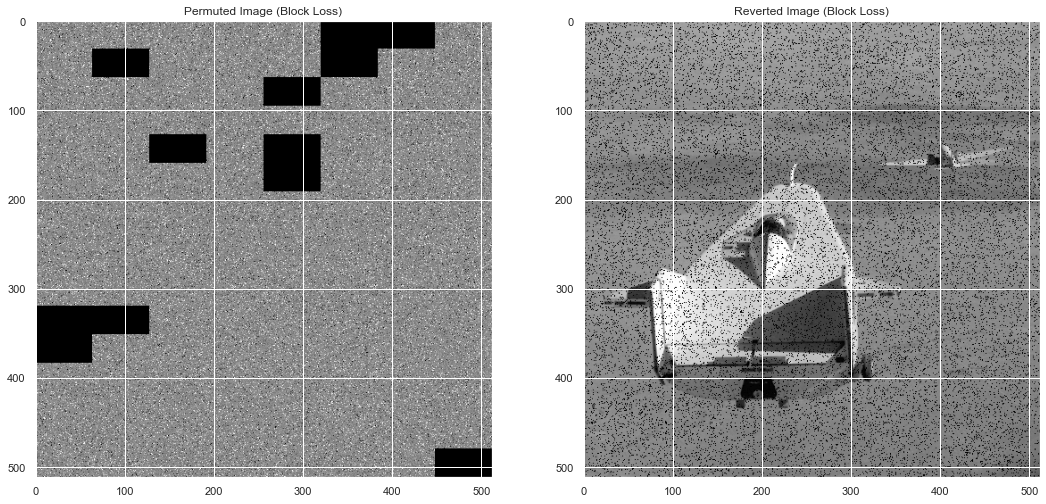

In [14]:
from skimage.util import view_as_blocks

# Range of (N x M) goes between 2**5 and 2**8 so a big block of the image is modified
n = np.random.choice([2**i for i in range(5, 8)])
m = np.random.choice([2**i for i in range(5, 8)])

# How many blocks (N x M) to distort randomly 
def block_loss(losses, im, n, m):
    img_hght = im.shape[0]
    view = view_as_blocks(permuted_img, block_shape=(n, m))
    for i in range(losses):
        random1 = np.random.choice(range(0, int(img_hght / n)))
        random2 = np.random.choice(range(0, int(img_hght / m)))
        view[random1, random2] = 0
    return im


lossy_img = block_loss(3, permuted_img, n, m)
print(lossy_img.shape)

fig2, axes = plt.subplots(1, 2, figsize = (18, 10))
ax = axes.ravel()
ax[0].imshow(lossy_img, cmap = 'gray')
ax[0].set_title('Permuted Image (Block Loss)')
ax[1].imshow(revert_permutation(permuted_img, permutation_matrix), cmap = 'gray')
ax[1].set_title('Reverted Image (Block Loss)')
plt.show()

Even though we completely *removed* three blocks (in my case) from the permuted image, we can still notice a couple of interesting effects after reverting the permutation back to the original image. First, the block loss isn't located on the same blocks that were removed from the image but however the error (small amounts of loss) is spread around all the pixels of the image. The original image is still detectable by the human eye so we can view it as a sign of robustness.

#### Noisy Images
Above we studied the effect of a permutation of an image and block loss distortion, what about noise though?

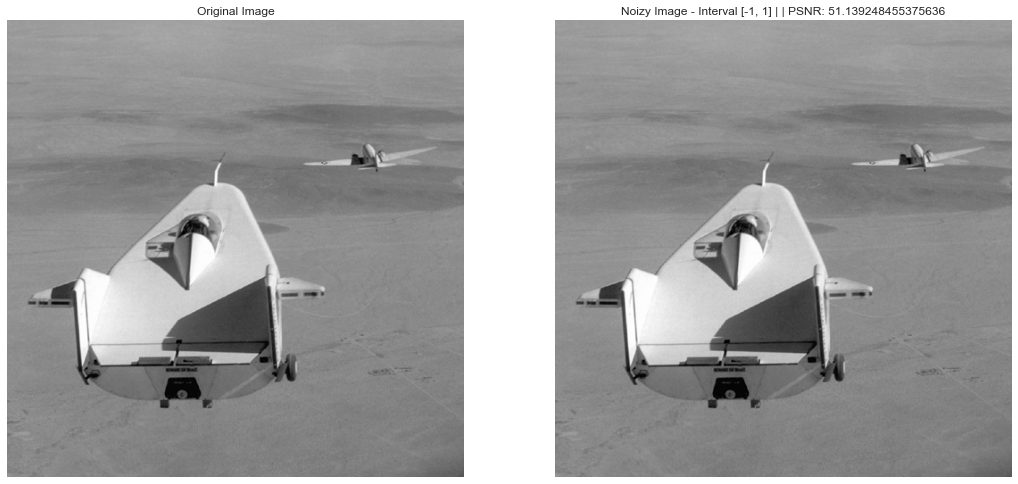

In [5]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import img_as_float, img_as_ubyte

def add_noise(im, interval_max):
    noise = np.random.rand(im.shape[0], im.shape[1]) * (interval_max * 2) - interval_max
    noizy_img = im + noise
    return np.clip(noizy_img, 0, 255).astype('uint8')

noizy_img = add_noise(grayscale_img, 1)

fig3, axes = plt.subplots(1, 2, figsize = (18, 10))
ax = axes.ravel() 
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(noizy_img, cmap = 'gray')
ax[1].set_title('Noizy Image - Interval [-1, 1] | | PSNR: {}'.format(peak_signal_noise_ratio(grayscale_img, noizy_img)))
ax[1].axis('off')
plt.show()

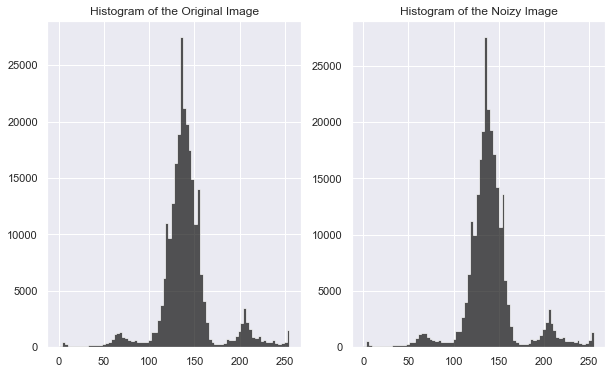

In [6]:
fig4, axes = plt.subplots(1, 2, figsize = (10, 6))
ax = axes.ravel() 
ax[0].set_title('Histogram of the Original Image')
ax[0].hist(grayscale_img.ravel(), bins = 80, color = 'black', histtype = 'stepfilled', alpha = 0.66)
ax[1].set_title('Histogram of the Noizy Image')
ax[1].hist(noizy_img.ravel(), bins = 80, color = 'black', histtype = 'stepfilled', alpha = 0.66)
plt.show()

Since we are doing the modifications on pixels of data types *uint-8* ranging from [0, 255], adding a noise generated from an interval of [-1, 1] has a minimal effect on the image itself or on the histogram () and thus provides a high psnr value of ~51. 

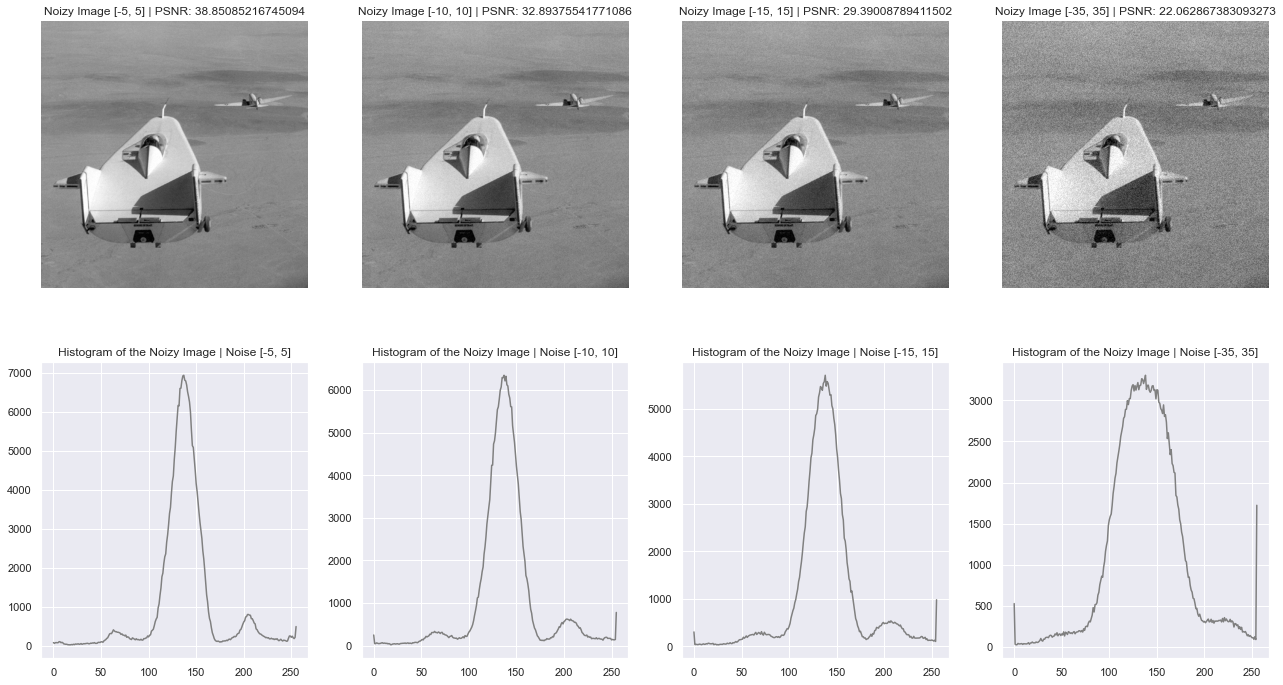

In [7]:
noise_intervals = [5, 10, 15, 35]

fig5, axes = plt.subplots(2, 4, figsize = (22, 12))
ax = axes.ravel()

for i in range(0, 4):
    noizy_img2 = add_noise(grayscale_img, noise_intervals[i])
    ax[i].imshow(noizy_img2, cmap = 'gray')
    ax[i].set_title('Noizy Image [{}, {}] | PSNR: {}'.format(-noise_intervals[i], noise_intervals[i], peak_signal_noise_ratio(grayscale_img, noizy_img2)))
    ax[i].axis('off')
    
    ax[i + 4].set_title('Histogram of the Noizy Image | Noise [{}, {}]'.format(-noise_intervals[i], noise_intervals[i]))
    histogram, bin_edges = np.histogram(noizy_img2, bins = 256, range = (0, 256))
    ax[i + 4].plot(bin_edges[0:-1], histogram, color = 'gray')

As we can see from the graphs above, the higher the noise values in our intervals, the higher the modification to the pixels (also considering the pixels who will get out the range and will be clipped back to [0, 255] thus causing the noise at the different parts of the plane displayed). This will lead to a lower and lower PSNR as values and histograms move away from the original distributions of the pixels of the image. The more the noise the *flatter* the histogram. 

### Basic Data Hiding
Below are implemented the methods to hide the secret image into the original image to provide the stego image and the extraction from the latter too, using bitmasks as it's the fastest method compared to Numpy or for loops.

In [8]:
%%time
cover_im = cv.imread('lena.png')
secret_im = cv.imread('baboon.png')

hidden_image = np.zeros(cover_im.shape, dtype = np.uint8)

blue_channel1 = ((secret_im[:, :, 0] >> 4) & 0b00000011)
blue_channel2 = (secret_im[:, :, 0] >> 6)
green_channel = (secret_im[:, :, 1] >> 3) & 0b00011100
red_channel   = (secret_im[:, :, 2] >> 5)

cover_im[:, :, 0] = cover_im[:, :, 0] & 0b11100000
cover_im[:, :, 1] = cover_im[:, :, 1] & 0b11111100
cover_im[:, :, 2] = cover_im[:, :, 2] & 0b11111000

hidden_image[:, :, 0]  = cover_im[:, :, 0] | green_channel
hidden_image[:, :, 0]  = hidden_image[:, :, 0] | blue_channel1
hidden_image[:, :, 1]  = cover_im[:, :, 1] | blue_channel2
hidden_image[:, :, 2]  = cover_im[:, :, 2] | red_channel

print('Steganography Complete')

Steganography Complete
CPU times: total: 0 ns
Wall time: 15 ms


In [11]:
%%time
extracted_image = np.zeros(hidden_image.shape, dtype = np.uint8)

blue_channel = hidden_image[:, :, 0]
green_channel = hidden_image[:, :, 1]
red_channel   = hidden_image[:, :, 2]

extracted_image[:, :, 0]  = (green_channel << 6) | ((blue_channel << 4) & 0b00110000)
extracted_image[:, :, 1]  = ((blue_channel << 3) & 0b11100000)
extracted_image[:, :, 2]  = red_channel << 5

print('Extraction Complete')

Extraction Complete
CPU times: total: 0 ns
Wall time: 1.98 ms


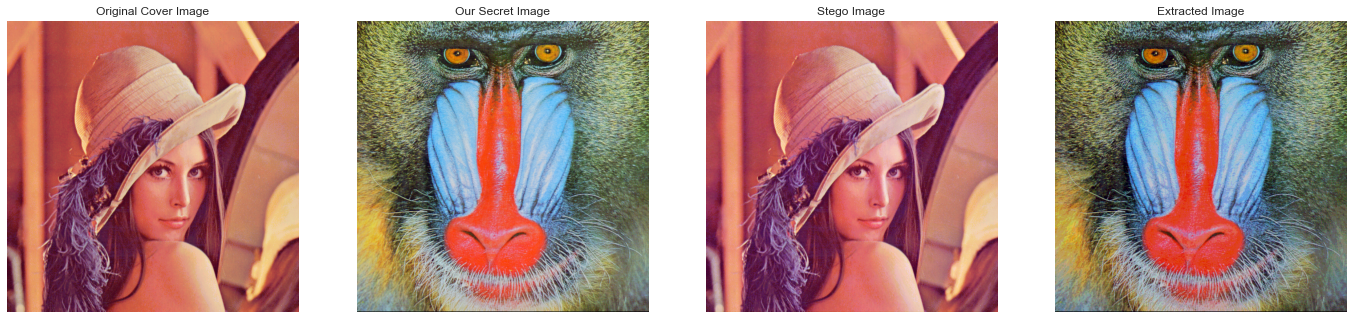

In [12]:
# Plotting them side by side
fig6, axes = plt.subplots(1, 4, figsize = (24, 10))
ax = axes.ravel() 
ax[0].imshow(cv.cvtColor(cover_im, cv.COLOR_BGR2RGB))
ax[0].set_title('Original Cover Image')
ax[0].axis('off')

ax[1].imshow(cv.cvtColor(secret_im, cv.COLOR_BGR2RGB))
ax[1].set_title('Our Secret Image')
ax[1].axis('off')

ax[2].imshow(cv.cvtColor(hidden_image, cv.COLOR_BGR2RGB))
ax[2].set_title('Stego Image')
ax[2].axis('off')

ax[3].imshow(cv.cvtColor(extracted_image, cv.COLOR_BGR2RGB))
ax[3].set_title('Extracted Image')
ax[3].axis('off')
plt.show()    

The data hiding algorithm or *steganography* was successfully completed according to the bit change on our given table. As we can see from the stego image, our secret is in no way whatsoever detectable. This was expected as we hid the bits on the least significant bits of our cover image and on the channels were HVS is less prone to detect changes. 
However when it comes to extracting our secret image back from the stego image, we get an image that is detectible from the human eye that it's the secret image but doesn't is somewhat different of the original. This is expected too since we only used the most important bits of our secret image and lost the rest so a decrease in quality was expected. 